Convolution

In [3]:
# Required imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

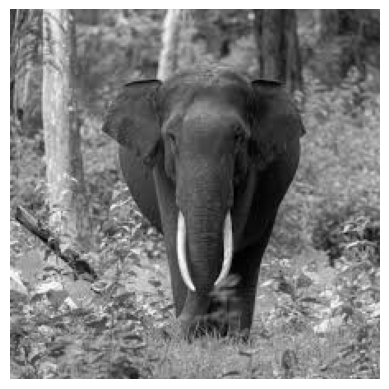

In [4]:
# Load image
img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.axis('off')


#1. Manual Convolution Implementation

Here we implement a manual 2D convolution function with the following features:
- Manual 2D convolution for a grayscale image.
- No built-in convolution functions are used.
- Supports zero-padding and even/odd kernel sizes.
- Output size is preserved.

In [5]:
def manual_convolution(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    # Convert inputs to float to avoid overflow and allow negative values
    image = image.astype(np.float32, copy=False)
    kernel = kernel.astype(np.float32, copy=False)

    # Image dimensions
    H, W = image.shape

    # Kernel dimensions
    Kh, Kw = kernel.shape

    # Define kernel anchor (center)
    # For even-sized kernels, integer division determines the anchor location
    anchor_y = Kh // 2
    anchor_x = Kw // 2

    # Compute zero-padding sizes so output size equals input size
    pad_top = anchor_y
    pad_left = anchor_x
    pad_bottom = Kh - 1 - anchor_y
    pad_right = Kw - 1 - anchor_x

    # Apply zero-padding explicitly (HW requirement)
    padded = np.pad(
        image,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0
    )

    # Initialize output image
    output = np.zeros((H, W), dtype=np.float32)

    # Iterate over each pixel in the original image
    for y in range(H):
        for x in range(W):
            # Extract local neighborhood corresponding to the kernel size
            patch = padded[y:y + Kh, x:x + Kw]

            # Compute weighted sum (correlation: kernel is NOT flipped)
            output[y, x] = np.sum(patch * kernel)

    return output

#2. Test Convolution Function

#A. Box filter (simple averaging blur)
In this task:
- The manual convolution function is applied with box filters of sizes 3×3, 5×5, and 7×7.
- Each filter performs uniform averaging over the local neighborhood of each pixel.


In [6]:
def box_kernel(size):
    # Create a normalized box (average) kernel of size (size x size)
    return np.ones((size, size), dtype=np.float32) / (size * size)

# Define box kernels with increasing window sizes
box_3 = box_kernel(3)
box_5 = box_kernel(5)
box_7 = box_kernel(7)

# Apply the manual convolution using each box filter
box3_img = manual_convolution(gray, box_3)
box5_img = manual_convolution(gray, box_5)
box7_img = manual_convolution(gray, box_7)


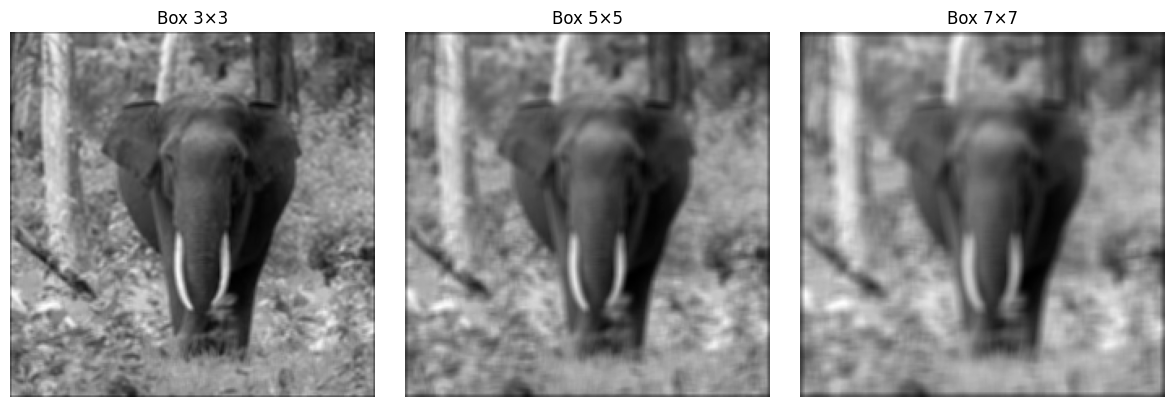

In [7]:

outputs = [box3_img, box5_img, box7_img]
titles = ["Box 3×3", "Box 5×5", "Box 7×7"]

# Generic utility function for displaying multiple grayscale images side by side
def show_images(images, titles, figsize=(12, 4)):
    plt.figure(figsize=figsize)

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(np.clip(img, 0, 255).astype(np.uint8), cmap="gray")
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(outputs,titles)



#B. Gaussian kernels
In this task:

- Gaussian filters of sizes 3×3, 5×5, and 7×7 are applied using the manual convolution function.
- Each filter applies weighted averaging, giving higher weight to pixels closer to the center.

In [8]:
def gaussian_kernel(size, sigma):
    # Create and normalize a 2D Gaussian kernel
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2)).astype(np.float32)
    return kernel / np.sum(kernel)

# Gaussian kernels (different sizes and sigmas)
gauss_3 = gaussian_kernel(3, 0.8)
gauss_5 = gaussian_kernel(5, 1.0)
gauss_7 = gaussian_kernel(7, 1.2)

# Apply manual convolution with Gaussian smoothing
gauss3_img = manual_convolution(gray, gauss_3)
gauss5_img = manual_convolution(gray, gauss_5)
gauss7_img = manual_convolution(gray, gauss_7)


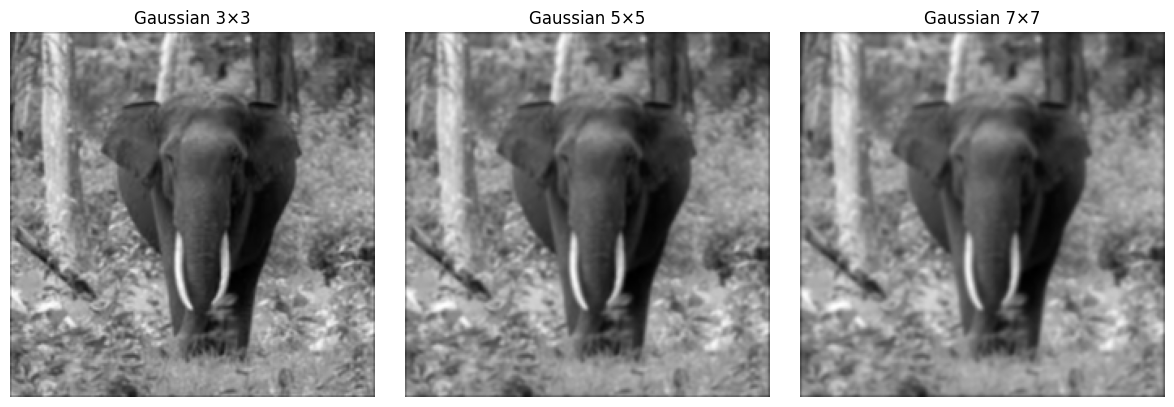

In [9]:
# Display results of Gaussian smoothing with increasing kernel sizes
gauss_imgs = [gauss3_img, gauss5_img, gauss7_img]
titles = ["Gaussian 3×3", "Gaussian 5×5", "Gaussian 7×7"]
show_images(gauss_imgs,titles)


#C. Sharpening kernels (3×3 only)
In this task:

- A 3×3 sharpening kernel and Sobel-X and Sobel-Y kernels are applied using the manual convolution function.
- The sharpening filter enhances edges.
- The Sobel kernels detect horizontal and vertical intensity changes.


In [10]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[-1, -2, -1],
                    [0,  0,  0],
                    [1,  2,  1]], dtype=np.float32)

sharpen_img = manual_convolution(gray, sharpen_kernel)
sobelx_img = manual_convolution(gray, sobel_x)
sobely_img = manual_convolution(gray, sobel_y)

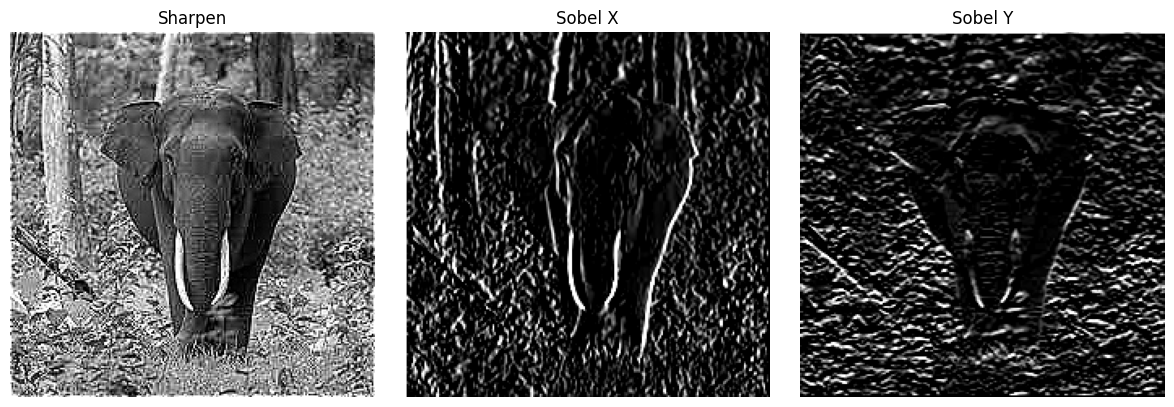

In [11]:
# Display sharpening and Sobel filter results
results = [sharpen_img, sobelx_img, sobely_img]
titles = ["Sharpen", "Sobel X", "Sobel Y"]
show_images(results,titles)



###3. Compare With OpenCV

In this section, the output of the manual convolution is compared with OpenCV’s cv2.filter2D
using the same kernels.

The comparison includes:
- Visual comparison of the filtered images.
- Numerical comparison using MAE and MSE over the full image.
- Local error analysis on a **border region** and a **central region**.

In [12]:
def mae(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.mean(np.abs(a - b))

def mse(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.mean((a - b) ** 2)


In [13]:
cv_box3 = cv2.filter2D(gray, -1, box_3)

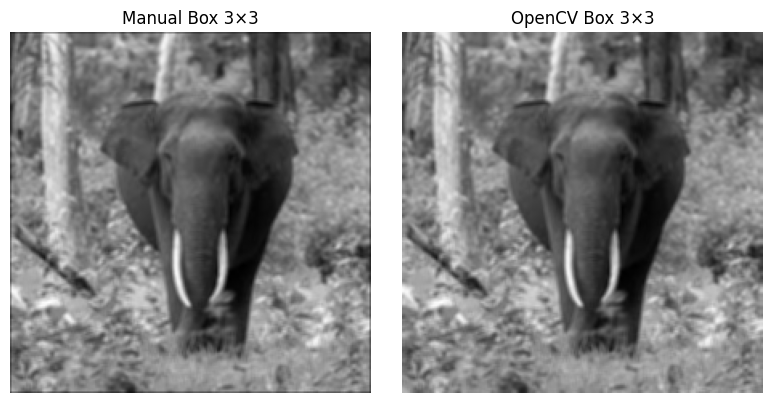

In [14]:
# Visual Comparison (Box 3×3 Example):


show_images(
    images=[box3_img, cv_box3],
    titles=["Manual Box 3×3", "OpenCV Box 3×3"],
    figsize=(8, 4)
)


In [15]:
# Numerical Comparison – Full Image:


full_mae = mae(box3_img, cv_box3)
full_mse = mse(box3_img, cv_box3)

print("Full image:")
print(f"MAE = {full_mae:.6f}, MSE = {full_mse:.6f}")


Full image:
MAE = 0.960922, MSE = 32.403236


In [16]:
#Local Error Analysis – Border vs Center:


kh, kw = box_3.shape

# Border region (top-left corner, affected by padding)
manual_border = box3_img[:kh, :kw]
opencv_border = cv_box3[:kh, :kw]

# Center region (not affected by padding)
cy, cx = gray.shape[0] // 2, gray.shape[1] // 2
half_h, half_w = kh // 2, kw // 2

manual_center = box3_img[cy-half_h:cy+half_h+1, cx-half_w:cx+half_w+1]
opencv_center = cv_box3[cy-half_h:cy+half_h+1, cx-half_w:cx+half_w+1]

print("\nBorder region:")
print(f"MAE = {mae(manual_border, opencv_border):.6f}, "
      f"MSE = {mse(manual_border, opencv_border):.6f}")

print("\nCenter region:")
print(f"MAE = {mae(manual_center, opencv_center):.6f}, "
      f"MSE = {mse(manual_center, opencv_center):.6f}")



Border region:
MAE = 12.999999, MSE = 315.348358

Center region:
MAE = 0.197528, MSE = 0.068586


**Conclusions:**

- The numerical error over the full image is low.

- The error measured on the border region is significantly higher than in the center region.

- The center region shows very small MAE and MSE values, indicating nearly identical results
away from image boundaries.

- This demonstrates that the main differences between the manual implementation and
cv2.filter2D are localized near the image borders.


#4. Compare Smoothing Behaviors


Box filtering applies uniform averaging over the window, which leads to stronger smoothing
and noticeable blurring of edges as the kernel size increases.

Gaussian filtering applies weighted averaging, giving higher importance to pixels near the center.
As a result, noise is reduced while edges are better preserved compared to simple averaging.

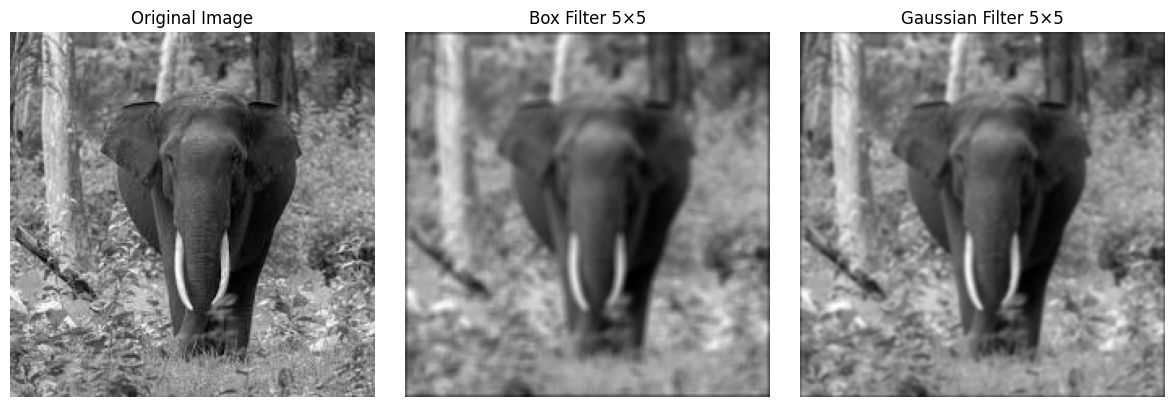

In [17]:
# Compare smoothing behavior using the same kernel size (5×5)

# Box and Gaussian kernels
box_5 = box_kernel(5)
gauss_5 = gaussian_kernel(5, sigma=1.0)

# Apply manual convolution
box5_img = manual_convolution(gray, box_5)
gauss5_img = manual_convolution(gray, gauss_5)

# Visual comparison
show_images(
    images=[gray, box5_img, gauss5_img],
    titles=["Original Image", "Box Filter 5×5", "Gaussian Filter 5×5"],
    figsize=(12, 4)
)


In [18]:
# Measure overall smoothing strength (variance reduction)
print("Variance (Original):", np.var(gray))
print("Variance (Box 5×5):", np.var(box5_img))
print("Variance (Gaussian 5×5):", np.var(gauss5_img))


Variance (Original): 2348.0160352320922
Variance (Box 5×5): 1852.5543
Variance (Gaussian 5×5): 1979.6698


#Smoothing Behavior Analysis:
- The box filter produces stronger smoothing, as reflected by a larger reduction in image variance.
- The Gaussian filter preserves edges better because pixels closer to the center receive higher weights,
while the box filter applies uniform averaging across the entire window.

#5. Explanation Differences Between our Output and OpenCV

**Summary of Observed Differences**

The results obtained from the manual convolution and OpenCV’s cv2.filter2D are not identical.

The differences can be explained by the following factors:





- Border handling:
The manual implementation uses explicit zero-padding, while OpenCV applies its own default border handling strategy.
As a result, differences are concentrated near the image boundaries.

- Kernel anchor and alignment:
OpenCV defines the kernel anchor internally, which may differ slightly from the manual anchor definition, especially for even-sized kernels.

- Numerical precision:
OpenCV uses optimized internal routines and may accumulate floating-point values in a different order, leading to small numerical differences.

- Data type conversions:
Conversions between uint8 and float32, as well as clipping for visualization, introduce additional numerical variation.

- Locality of differences:
Quantitative analysis shows that errors are significantly higher near the image borders, while the central region exhibits very low MAE and MSE values.

- Overall, the observed differences are limited in scope, localized mainly at the borders, and are consistent